# Run ML algorithms

In [2]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

from hpsklearn import HyperoptEstimator, svc, k_neighbors_classifier, logistic_regression, ada_boost_classifier, decision_tree_classifier



In [14]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')


In [15]:
twitter.head()

,Unnamed: 0,text,verdict
0,0,ohio police officer hospitalized after eating ...,False
1,1,one of the men who wanted to copy the orlando...,False
2,2,missouri governor declares state of emergency ...,False
3,3,the iphone plus really does have a bending p...,False
4,4,paul walker dies millions cried millions die...,True


In [17]:
# Prep data / Encode text

tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = HashingVectorizer(n_features=2**14)
#Fix this - encode the datasets together
all_statements = np.append(politifact['statement'].values, pheme['text'].values)

all_tf = tfidf.fit_transform(all_statements)
polit_tf = all_tf[:21152]
pheme_tf = all_tf[21152:]

twitter_tf = tfidf.fit_transform(twitter['text'])

#polit_tf = tfidf.fit_transform(politifact['statement'].values)
#pheme_tf = tfidf.fit_transform(pheme['text'].values)

cv = CountVectorizer()
X_cv = cv.fit_transform(pheme['text'].values)

print(polit_tf.shape)
print(pheme_tf.shape)
print(twitter_tf.shape)

(21152, 17894)
(2402, 17894)
(1729, 4188)


In [24]:
# Select encoding
X = pheme_tf
#X = X_cv
y = pheme['target']

rs = 42

method = 3

if method == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs)
elif method == 1:
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_test = pheme_tf
    y_test = pheme['target']
    X_train = twitter_tf
    y_train = twitter['verdict']
else:
    X_test = pheme_tf
    y_test = pheme['target']
    X_train = polit_tf
    y_train = politifact['verdict']


###Things to do: add more features

In [6]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [19]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [22]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=20)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [28]:
# SVM
svm = optimize_model(svc("mySVC"), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.92s/trial, best loss: 0.12188365650969524]
{'learner': SVC(C=0.9852876843464358, coef0=0.800700984120711, degree=4, random_state=4,
    shrinking=False, tol=0.00970440159075791), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 84.53 %
F1: 84.35 %


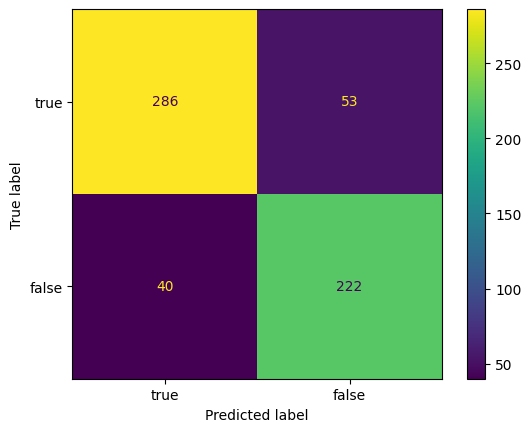

In [29]:
evaluate_model(svm, X_test, y_test)

In [21]:
# KNN
from sklearn.neighbors import VALID_METRICS_SPARSE
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN", metric=knn_metrics), X_train, y_train)


100%|██████████| 50/50 [00:06<00:00,  6.14s/trial, best loss: 0.08076923076923082]
{'learner': KNeighborsClassifier(algorithm='brute', leaf_size=20, metric='euclidean',
                     n_jobs=1, n_neighbors=2, p=2.1246056243037277,
                     weights='distance'), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 89.84 %
F1: 89.04 %


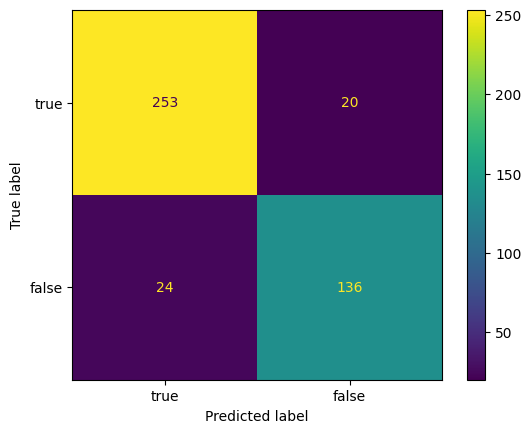

In [23]:
evaluate_model(knn, X_test, y_test)

In [57]:
# Logistic Regression logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.20s/trial, best loss: 0.14404432132963985]
{'learner': LogisticRegression(C=1.5505403080866935, max_iter=270, n_jobs=1, random_state=0,
                   solver='liblinear', tol=0.0001487098203537736), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 84.19 %
F1: 84.01 %


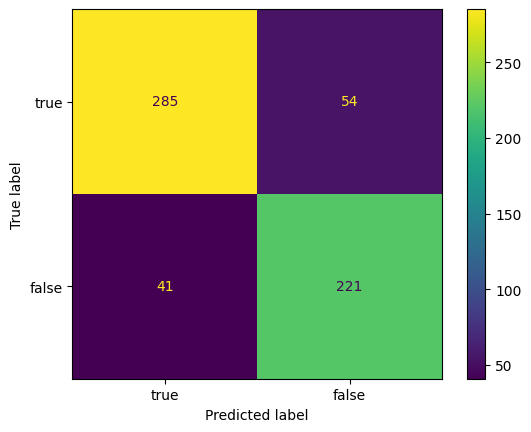

In [58]:
evaluate_model(myLR, X_test, y_test)

In [62]:
# AdaBoost
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", estimator=baseDT), X_train, y_train)

 50%|█████     | 1/2 [00:04<?, ?trial/s, best loss=?]


c:\Users\willc\miniconda3\envs\rumour-ensemble\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 82.36 %
F1: 0.8227197845009906


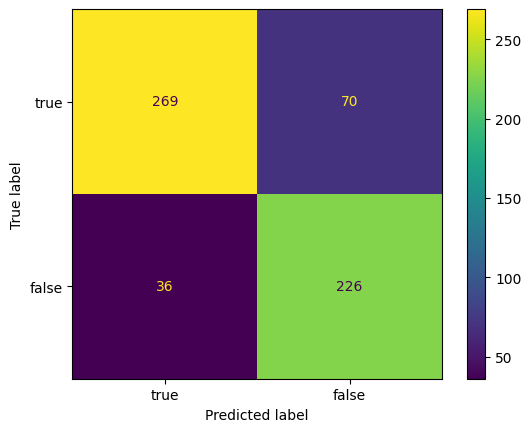

In [ ]:
# Run model with best results
evaluate_model(ada, X_test, y_test)